# FRDC Tutorial

To help you get started with the FRDC library, we've created a short onboarding tutorial.

The tutorial will cover the most common use cases:
- Firstly, we'll load in our dataset, perform an auto-segmentation.
- Then we'll show you how to get the pre-labelled segments.
- Finally, the tutorial ends and you're free to train your own model with the segments.

## Setup

Currently, our dataset is not open sourced, and only available internally to members of the FRDC team.
The recommended approach for authentication is to use ADC (Application Default Credentials) to authenticate with GCS.
See: https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev

### Imports

Secondly, know that you can import our packages with `from frdc.___ import ___`
Here are some common imports that you'll need to get started.


In [1]:
from __future__ import annotations

import numpy as np

from frdc.load import FRDCDataset

# Retrieving our Dataset

> Note that your `.secrets` folder should have the `.json` API keys for GCS.

In [2]:
ds = FRDCDataset('chestnut_nature_park', '20201218', None)

`ds` contains the information about the dataset. We'll retrieve the `np.ndarray` bands of the dataset.

In [3]:
# ds = FRDCDataset._load_debug_dataset()

# Previous code:
#   ar = ds.get_ar_bands()

# New in v0.1.0
# The ar is still the same, but we also return the order of the bands
ar, order = ds.get_ar_bands()

print(f"{ar.shape=}, {ar.dtype=}")
# bounds, labels = ds.get_bounds_and_labels()

ar.shape=(7620, 4876, 8), ar.dtype=dtype('float32')


The shape of the array is [Height, Width, Bands]. Notably, the Bands are ordered by their wavelength:
- BLUE = 0
- GREEN = 1
- RED = 2
- RED_EDGE = 3
- NIR = 4

Programmatically, you can access these indices with `frdc.conf.Band.BLUE`, `frdc.conf.Band.GREEN`, etc.
This is so that you can consistently access the bands without guessing the order.

For example, let's plot the RGB image of the dataset. We do a min-max normalization and a square root transform to make the image look nicer. This is a function so that we can reuse it later.

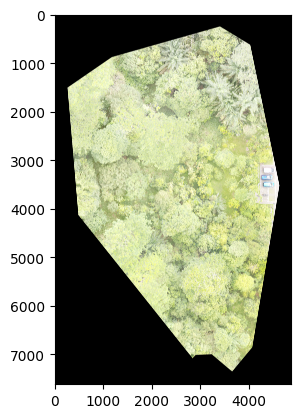

In [4]:
import matplotlib.pyplot as plt


def show_image(_ar: np.ndarray):
    # New in v0.1.0
    # We use the order to get the RGB bands, here we can specify if it's using the
    # wide or narrow bands
    _ar = _ar[:, :, [order.index('WR'), order.index('WG'), order.index('WB')]]
    _ar = (_ar - np.nanmin(_ar)) / (np.nanmax(_ar) - np.nanmin(_ar))
    plt.imshow(_ar ** 0.5)
    plt.show()


show_image(ar)

# Auto-Segmentation

Next, we'll perform an auto-segmentation on the dataset via `compute_labels`. This performs the watershed algorithm on the dataset and returns a labelled image.
Each integer in the labelled image represents a different segment.

We can adjust parameters such as `peaks_footprint` and `watershed_compactness` to change the segmentation.
Here, the parameters are unoptimized, so it's not perfect.

In [5]:
from skimage.morphology import remove_small_objects, remove_small_holes
from frdc.preprocess.morphology import threshold_binary_mask, binary_watershed
from frdc.preprocess.scale import scale_0_1_per_band

# New in v0.1.0
# We are deprecating `compute_labels` to promote the use of separate functions.
# This is so that users know what the function is doing.

ar = scale_0_1_per_band(ar)
ar_mask = threshold_binary_mask(ar, order.index('NIR'))
ar_mask = remove_small_objects(ar_mask, min_size=100, connectivity=2)
ar_mask = remove_small_holes(ar_mask, area_threshold=100, connectivity=2)
ar_labels = binary_watershed(ar_mask)

print(f"{ar_labels.shape=}, {ar_labels.dtype=}")

ar_labels.shape=(7620, 4876), ar_labels.dtype=dtype('int32')


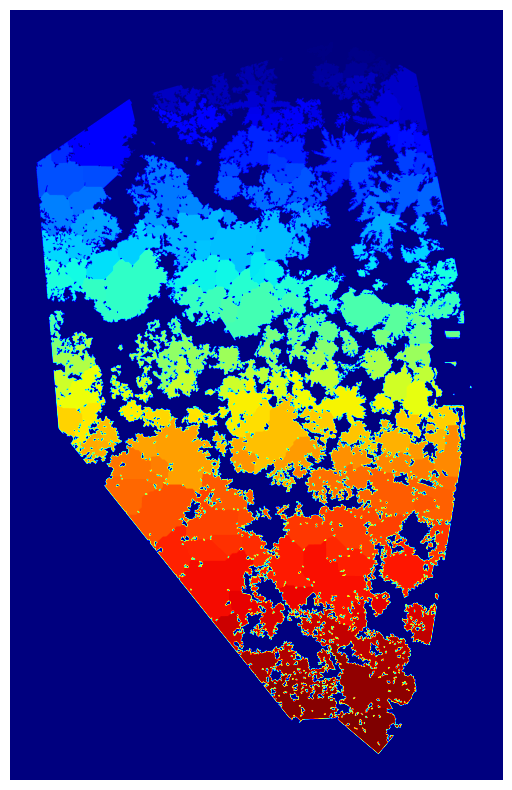

In [6]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(ar_labels, cmap='jet')
plt.show()

## Removing Small Segments
Before we move further, some segments may be too small to be of interest.
We can use the `remove_small_segments_from_labels` function to remove small segments.

In our tutorial, we'll be more conservative and remove segments that are smaller than 200x200 pixels.

In [7]:
from frdc.preprocess.extract_segments import remove_small_segments_from_labels

ar_labels = remove_small_segments_from_labels(ar_labels, min_height=200, min_width=200)

One thing to notice about the `ar_labels` is that it's just integers representing the different segments.
Thus, we have a separate function `extract_segments_from_labels` to extract the segments from the bounds.

Here, the function returns a list of `np.ndarray` segments, each of shape [Height, Width, Bands].
Importantly, the **first** segment is the background segment, thus it may of interest to you to remove it.

In [8]:
from frdc.preprocess.extract_segments import extract_segments_from_labels

segments: list[np.ndarray] = extract_segments_from_labels(ar, ar_labels, cropped=True)
for ar_segment in segments[:5]:
    print(f"{ar_segment.shape=}, {ar_segment.dtype=}")

ar_segment.shape=(7620, 4876, 8), ar_segment.dtype=dtype('float32')
ar_segment.shape=(366, 360, 8), ar_segment.dtype=dtype('float32')
ar_segment.shape=(206, 267, 8), ar_segment.dtype=dtype('float32')
ar_segment.shape=(218, 244, 8), ar_segment.dtype=dtype('float32')
ar_segment.shape=(379, 236, 8), ar_segment.dtype=dtype('float32')


## Background Segment

The first segment is the background segment. We can plot it to see what it looks like.

G:\Repositories\FRDC-ML\venv\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


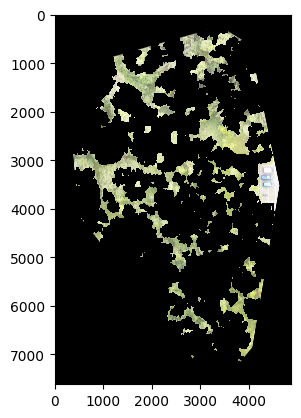

In [9]:
show_image(segments[0])

## Tree 1 Segment

The second segment is the first tree segment. We can plot it to see what it looks like.
Obviously, this heavily depends on a good segmentation. If the segmentation is bad, then the segments will be bad.

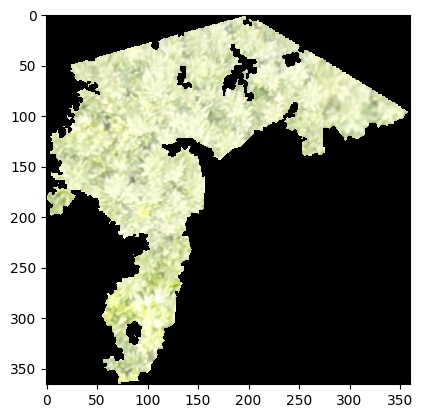

In [10]:
show_image(segments[1])

# Using pre-labelled segments

Instead of doing our auto-segmentation, it's best to use curated segments. It's trivial with the `ds` object

The bounds is a list of tuples (coords in the format i.x0, i.y0, i.x1, i.y1),
and the labels is a list of strings representing the segment tree name.

In [11]:
bounds, labels = ds.get_bounds_and_labels()
for bound, label in list(zip(bounds, labels))[:5]:
    print(f"{bound=}, {label=}")

bound=Rect(x0=1841, y0=2187, x1=2541, y1=3018), label='Falcataria Moluccana'
bound=Rect(x0=812, y0=2422, x1=1348, y1=2962), label='Ficus Variegata'
bound=Rect(x0=1049, y0=3095, x1=1709, y1=3552), label='Bridelia Sp.'
bound=Rect(x0=1243, y0=4317, x1=1783, y1=4876), label='Falcataria Moluccana'
bound=Rect(x0=1850, y0=5118, x1=2232, y1=5862), label='Falcataria Moluccana'


## Segmenting with bounds

You don't need to segment yourself, you can use the `extract_segments_from_bounds` function to extract segments from the bounds.

In [13]:
from frdc.preprocess.extract_segments import extract_segments_from_bounds

# We reload the ar bands as the bounds is relative to the original image
# New in v0.1.0
# The ar is still the same, but we also return the order of the bands
ar, order = ds.get_ar_bands()
segments: list[np.ndarray] = extract_segments_from_bounds(ar, bounds, cropped=True)

Here, we have segments of different shapes and dtypes.

In [14]:
for ar_segment in segments[:5]:
    print(f"{ar_segment.shape=}, {ar_segment.dtype=}")

ar_segment.shape=(831, 700, 8), ar_segment.dtype=dtype('float32')
ar_segment.shape=(540, 536, 8), ar_segment.dtype=dtype('float32')
ar_segment.shape=(457, 660, 8), ar_segment.dtype=dtype('float32')
ar_segment.shape=(559, 540, 8), ar_segment.dtype=dtype('float32')
ar_segment.shape=(744, 382, 8), ar_segment.dtype=dtype('float32')


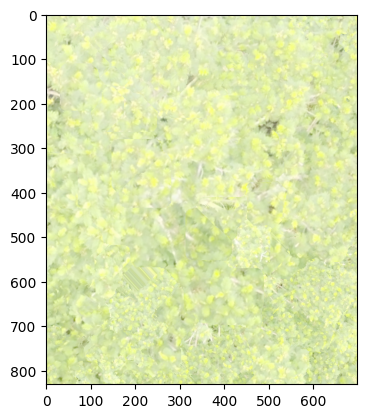

In [15]:
show_image(segments[0])

# Training a Model
It's up to you on how the model is trained, so the tutorial will not go into details on how to train a model. Note that our segments is a `list[np.ndarray]`, the array shapes are not guaranteed to be consistent. Finally, use our `labels` object to get the labels for each segment.


In [16]:
# Your model here:

We do have a baseline test that you can take a look at that uses PyTorch Lightning for training.
See: FRDC-ML/pipeline/model_tests/chestnut_dec_may/main.py

